## Least Squared Linear Regression
## Mini-batch stochasitc gradient

Generate random data for the model:
$$y=\beta_{0}+\beta_{1}x_1+\dots+\beta_{n}x_n+e$$
where $e\sim N(0,\sigma^{2})$

In [1]:
%matplotlib notebook
import numpy as np
import time
import random

nsample = 1000
nvariables=10
X0 = np.ones([nsample,1]) #the firt column are ones for the beta_0
X1 = np.random.uniform(0,10,([nsample,nvariables]))
X = np.concatenate([X0, X1],axis=1)
beta=np.random.randint(-5,5,size=([nvariables+1,1]));beta
error=np.random.normal(0,1,(nsample,1))#normal random error
Y=np.dot(X,beta)+error
#print(beta)
#error=np.random.normal(0,1,(nsample,1))#normal random error
#Y=X*beta+error

We can plot with respect to any of the variables:

(<matplotlib.collections.PathCollection at 0x16efd5e0e20>,
 Text(0.5, 0, 'X'),
 Text(0, 0.5, 'Y_p'))

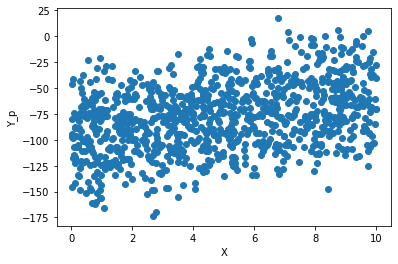

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
Y_p=np.array(Y)#convert to array for ploting
plt.scatter(X[:,5], Y_p),plt.xlabel('X'),plt.ylabel('Y_p')
#plt.scatter(X2, Y_p),plt.xlabel('X2'),plt.ylabel('Y_p')
#plt.scatter(X3, Y_p),plt.xlabel('X3'),plt.ylabel('Y_p')

Fit a linear relation between a set of variables ($X$) with respect to a response variable ($y$)

Model: $y = X\beta + u$

Classical estimation: least squares

  \begin{align*}
\text{minimize}\quad & ||y-X\beta||_2^2
\end{align*}

The exact solution is: $\beta_{ls}=(X^T X)^{-1}X^T y$

In [3]:
time_start = time.time()
beta_ls_exact=np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),Y)
time_elapsed = (time.time() - time_start)
print('time elapsed=',time_elapsed)
print(beta_ls_exact)

time elapsed= 0.0020356178283691406
[[-2.11358279]
 [-3.00594409]
 [-4.98262307]
 [-5.00166924]
 [ 1.02273031]
 [ 3.99663007]
 [-3.00042912]
 [-2.00061684]
 [ 1.99044186]
 [-4.99589663]
 [ 1.00547395]]


We now compute the least squares problem:

In [4]:
from scipy.optimize import minimize


def least_sq_reg(beta_ls, X, Y):
    beta_ls=np.matrix(beta_ls)
    #z=Y-np.dot(X,np.transpose(beta_ls))
    z=Y-X*np.transpose(beta_ls)
    return np.dot(np.transpose(z),z)

#beta_ls0 = np.matrix([0, 0, 0, 0])
beta_ls0 = np.zeros(nvariables+1)
time_start = time.time()
res = minimize(least_sq_reg, beta_ls0, args=(X, Y), method='Nelder-Mead', options={'disp': True,'xtol': 1e-10})
time_elapsed = (time.time() - time_start)
print('time elapsed=',time_elapsed)
print (res.x) 
print('error=',np.linalg.norm(np.transpose(beta_ls_exact)-res.x,ord=2)/np.linalg.norm(np.transpose(beta_ls_exact),ord=2))

time elapsed= 0.30803513526916504
[ 5.63351762 -0.43739906 -2.67688024 -4.84609471 -5.18694928 -2.93137193
  4.17416841 -1.81778925  0.012393   -2.44519836  0.84756167]
error= 1.3371637702509016


Or introduce ourselves the gradient and hessian information:

In [5]:
def least_sq_reg_der(beta_ls,X,Y):
    beta_ls=np.matrix(beta_ls)
    pp=-2*np.dot(np.transpose(Y-np.dot(X,np.transpose(beta_ls))),X)
    aa= np.squeeze(np.asarray(pp))
    return aa

def least_sq_reg_hess(beta_ls,X,Y):
    ss=2*np.dot(np.transpose(X),X)
    return ss



time_start = time.time()
#run your code
                   
res = minimize(least_sq_reg, beta_ls0, args=(X, Y), method='Newton-CG', jac=least_sq_reg_der, hess=least_sq_reg_hess, options={'disp': True})
time_elapsed = (time.time() - time_start) 
print('time elapsed=',time_elapsed)
print(res.x)
np.linalg.inv(least_sq_reg_hess(res.x,X,Y))
print('error=',np.linalg.norm(np.transpose(beta_ls_exact)-res.x,ord=2)/np.linalg.norm(np.transpose(beta_ls_exact),ord=2))
   

Optimization terminated successfully.
         Current function value: 1054.126518
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 8
time elapsed= 0.0035746097564697266
[-2.11357454 -3.00594399 -4.98262337 -5.0016695   1.0227302   3.99663005
 -3.00042929 -2.00061719  1.99044173 -4.99589681  1.00547374]
error= 7.44994930978192e-07


### Stochastic Gradient - Mini Batch

In [13]:
import random
### Redefine gradient function, to calculate the gradient just with the indexes passed as parameters
def least_sq_reg_der_stoc(beta_ls,X,Y,subset):
    beta_ls=np.matrix(beta_ls)
    Xsub = np.matrix(X[subset,:])
    Ysub = np.matrix(Y[subset,:])    
    pp=-2*np.dot((Ysub-np.dot(Xsub,beta_ls.T)).T,Xsub).T
    aa= np.squeeze(np.asarray(pp))
    return aa

(a,b)=X.shape
beta_lsg=np.zeros(b) #initial value for beta
alpha=1e-4
n_iter=100000#maximim number iteration
OF_iter=np.zeros(n_iter)
tol_iter=np.zeros(n_iter)
alpha_iter=np.zeros(n_iter)
error_minib_iter=np.zeros(n_iter)
i=0;
tol=100000;
epsilon=1e-9

#### Number of samples to take into consideration in each iteration
subsetsize = 10
#### Calculate one set of subsetsize random index to choose radomly some samples 
subsets = np.random.choice([x for x in range(0,a)],n_iter*subsetsize)
subsets.resize(n_iter,subsetsize)

time_start = time.time()

while (i <= n_iter-2) and (tol>epsilon):
    grad = least_sq_reg_der_stoc(beta_lsg, X, Y,subsets[i])
    ddirect = -grad
    beta_lsg = beta_lsg + alpha * ddirect
    OF_iter[i] = least_sq_reg(beta_lsg, X, Y)
    if i>0:
        tol = np.abs((OF_iter[i]-OF_iter[i-1])/OF_iter[i-1])
    tol_iter[i] = tol
    error_minib_iter[i] = np.linalg.norm(np.transpose(beta_ls_exact)-beta_lsg,ord=2)/np.linalg.norm(beta_lsg,ord=2)
    i=i+1
time_elapsed = (time.time() - time_start) 
print('time elapsed =',time_elapsed)
print('iterations =',i)
print('Objective Function value =', OF_iter[i])
print('Betas =',beta_lsg)
print('Tolerance=',tol)
print('error=',np.linalg.norm(np.transpose(beta_ls_exact)-beta_lsg,ord=2)/np.linalg.norm(beta_lsg,ord=2))

time elapsed = 19.393447160720825
iterations = 99999
Objective Function value = 0.0
Betas = [-2.10774027 -3.0048553  -4.99245135 -4.99948905  1.01644103  4.013743
 -3.00623839 -1.99830788  1.98515201 -5.00255053  1.00553768]
Tolerance= 0.030132346615095288
error= 0.0021675106491310485


<ipython-input-7-ce31ddaf333e>:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(error_minib_iter))


Text(0, 0.5, 'error')

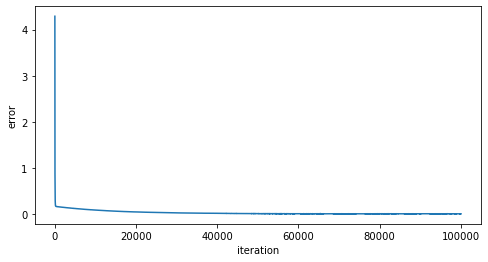

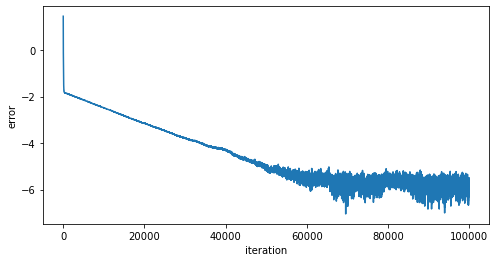

In [7]:
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_minib_iter)
plt.xlabel('iteration')
plt.ylabel('error')

plt.fig = plt.figure(figsize=(8,4))
plt.plot(np.log(error_minib_iter))
plt.xlabel('iteration')
plt.ylabel('error')

Text(0, 0.5, 'error')

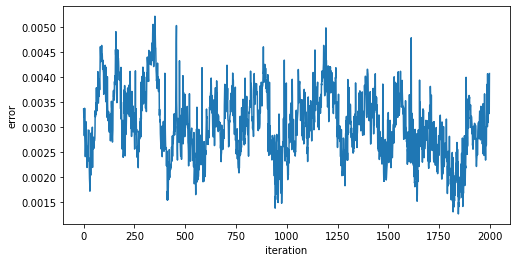

In [8]:
n_last=2000
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_minib_iter[-n_last:-1])
plt.xlabel('iteration')
plt.ylabel('error')

### Batch gradient (comparison)

In [9]:
(a, b) = X.shape
niter = 100000
epsilon = 1e-3
i = 0
alpha = 1e-6 #need to be reescaled, the OF is nsample times higher
OF_iter = np.zeros(niter)
tol_iter = np.zeros(niter)
error_grad_iter = np.zeros(niter)
tol = 10
beta_grad = np.zeros(b)


time_start = time.time()

while (i < niter) and (tol > epsilon): 
    grad = least_sq_reg_der(beta_grad.T, X, Y)
    beta_grad=beta_grad-alpha*grad
    tol = np.linalg.norm(grad, ord = 2)
    OF_iter[i]  = least_sq_reg(beta_grad, X, Y)
    tol_iter[i] = tol
    error_grad_iter[i] = np.linalg.norm(np.transpose(beta_ls_exact) - beta_grad, ord = 2)/np.linalg.norm(beta_ls_exact, ord = 2)
    i +=1     
time_elapsed = (time.time() - time_start)
print('time elapsed =',time_elapsed)
print('betas grad =',beta_grad)
print('betas exact =', beta_ls_exact.T)
print('number iterations =',i)
print('tolerance=',tol) 
print('final error =', np.linalg.norm(np.transpose(beta_ls_exact) - beta_grad, ord = 2)/np.linalg.norm(beta_ls_exact, ord = 2)) 

time elapsed = 37.010634422302246
betas grad = [-2.11122917 -3.00598105 -4.98267114 -5.00171786  1.02269209  3.99658566
 -3.00047348 -2.00066861  1.99039317 -4.99594539  1.005423  ]
betas exact = [[-2.11358279 -3.00594409 -4.98262307 -5.00166924  1.02273031  3.99663007
  -3.00042912 -2.00061684  1.99044186 -4.99589663  1.00547395]]
number iterations = 100000
tolerance= 0.15664654857208524
final error = 0.00021236897033900912


<ipython-input-10-70de2cfd9f91>:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(error_minib_iter))


(-8.0, -2.0)

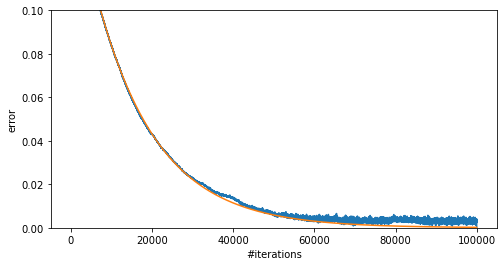

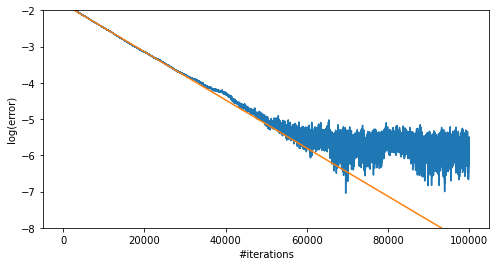

In [10]:
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_minib_iter)
plt.plot(error_grad_iter)
plt.xlabel('#iterations')
plt.ylabel('error')
plt.ylim([0,0.1])

plt.fig = plt.figure(figsize=(8,4))
plt.plot(np.log(error_minib_iter))
plt.plot(np.log(error_grad_iter))
plt.xlabel('#iterations')
plt.ylabel('log(error)')
plt.ylim([-8,-2])

Text(0, 0.5, 'error')

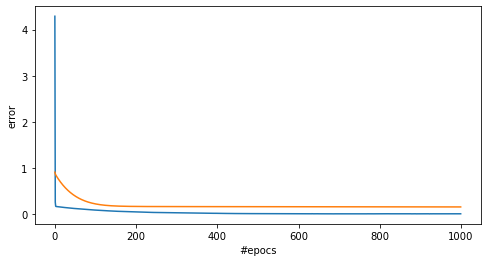

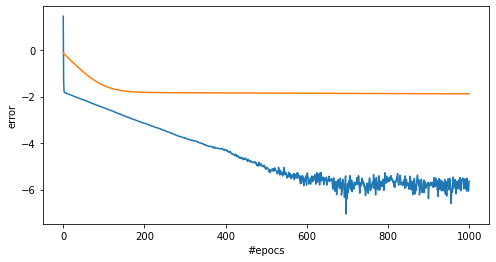

In [11]:
plt.fig = plt.figure(figsize=(8,4))
plt.plot(error_minib_iter[::(nsample//subsetsize)])
plt.plot(error_grad_iter[:error_minib_iter[::(nsample//subsetsize)].size])
plt.xlabel('#epocs')
plt.ylabel('error')

plt.fig = plt.figure(figsize=(8,4))
plt.plot(np.log(error_minib_iter[::(nsample//subsetsize)]))
plt.plot(np.log(error_grad_iter[:error_minib_iter[::(nsample//subsetsize)].size]))
plt.xlabel('#epocs')
plt.ylabel('error')